# Solve the latent variable Gaussian Graphical model using cvxpy

In [1]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import os
from os import getcwd
from os.path import dirname
from time import gmtime, strftime
import scipy as sp
import cvxpy as cvx
from sklearn.linear_model import lars_path
%matplotlib inline 
import sys

cwd = getcwd()
dir_root = dirname(cwd)
filepath = os.path.join(dir_root, 'src')
sys.path.append(filepath) #('/home/tianpei/Dropbox/Codes/Python/LatNet/src/')
print(filepath)
%load_ext Cython

/home/tianpei/Dropbox/Codes/Python/LatNet/src


In [2]:
from latent_random_network import stochastic_block_network as sbn 

In [3]:
b = 0.8 #1.5
a = 5.5 #8
(np.sqrt(a) - np.sqrt(b) >= np.sqrt(2))

True

In [4]:
savefigure = False
seed = 1000
choice = 'partition'
d = 12
size = [10, 8, 5]

In [5]:
p_out = b*np.log(sum(size))/sum(size)
p_in = a*np.log(sum(size))/sum(size)
p_in, p_out

(0.74979209511349232, 0.10906066838014435)

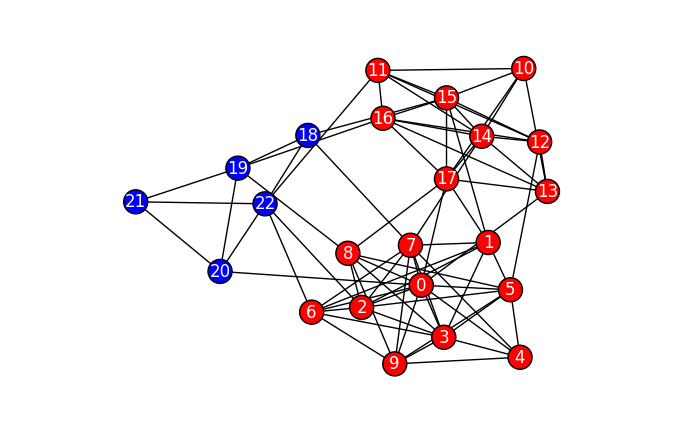

In [6]:
prob = [p_in, p_out]
option= {'seed': seed, 'node_dim': d, 'model': choice}
option['cutoff_freq'] = 12
SBN = sbn(size, prob, option)
G0 = SBN.graph_build(size=size, prob=prob, option=option, show_font=True, save_fig=savefigure)

In [7]:
node_sets = []
node_sets.append(set(np.arange(sum(size[0:len(size)-1]))))
node_sets.append(set(sum(size[0:len(size)-1])+np.arange(size[-1])))
node_lists = [list(node_sets[0]), list(node_sets[1]) ]

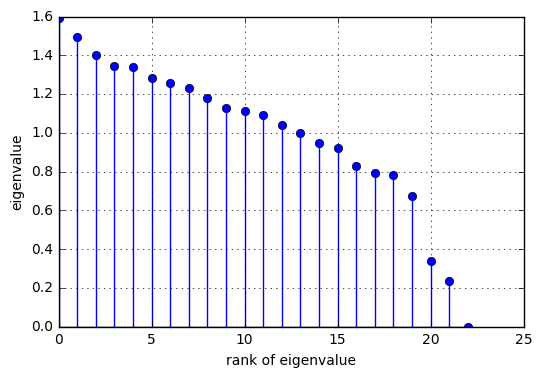

In [8]:
#Plot the eigenvalue of Laplacian matrix
Laplacian = nx.normalized_laplacian_matrix(G0).todense()
#Sigma, U = np.linalg.eigh(abs(adjMat))
Sigma, U = np.linalg.eigh(Laplacian)

index_sig = np.argsort(Sigma)
Sigma = Sigma[index_sig[::-1]]
U = U[:,index_sig[::-1]]

fig3 =plt.figure(3)
ax = plt.gca()
(markerline, stemlines, baseline) = plt.stem(np.arange(len(Sigma)), Sigma, 'b', basefmt='k-')
#plt.plot(np.arange(len(Sigma)), np.ones((len(Sigma, ))), 'r')
plt.xlabel('rank of eigenvalue')
plt.ylabel('eigenvalue')
ax.grid(True)
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_laplacian.eps"
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_adjMat.eps"
if savefigure : fig3.savefig(filename)

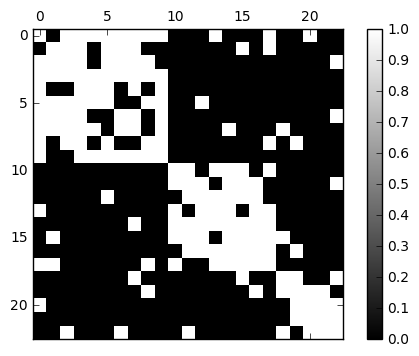

In [9]:
import pywt
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2)
ax = fig2.add_subplot(111)


cax = ax.matshow(sp.sign(abs((Laplacian))), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()

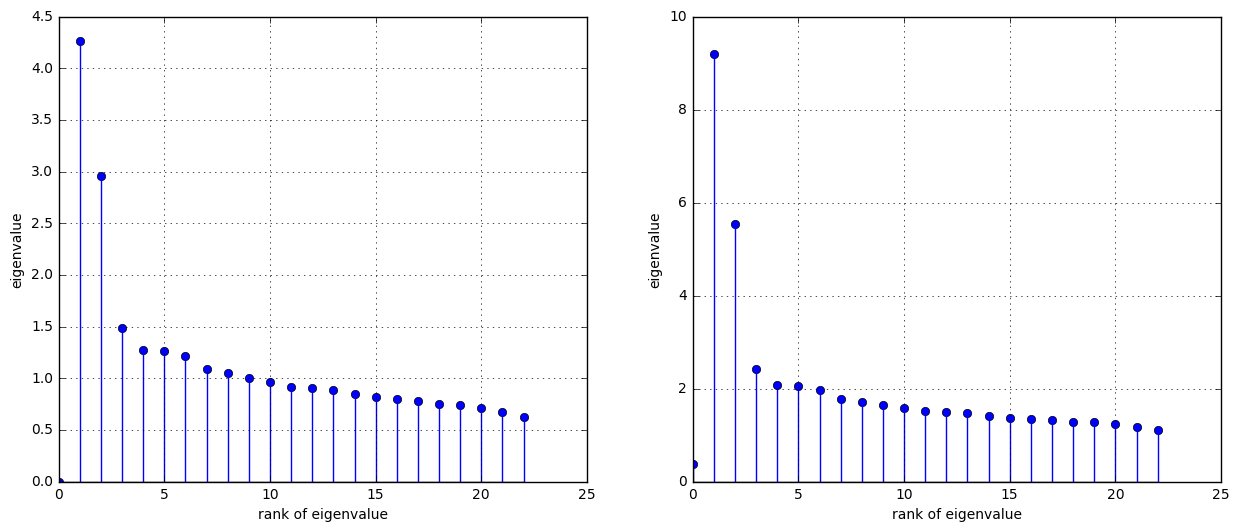

In [10]:
Tmax = 1
option_sig = {}
option_sig['mat'] = 'inverse_laplacian_matrix' #'adjacency_matrix'
choice2 = 'polynomial'

if choice2 == 'l1_threshold':
    option_sig['method'] = choice2
    option_sig['threshold'] = 0.5
elif choice2 == 'polynomial':
    option_sig['method'] = choice2
    degree_val = np.array(list(G0.degree().values()))
    bias = 1/np.sqrt(np.mean(degree_val))
    option_sig['coeffs'] = [bias, 1,0.25]
elif choice2 == 'rescale':
    option_sig['method'] = choice2
    option_sig['weights'] = np.random.rand((len(G0),))
elif choice2 == 'sigmoid_theshold':
    option_sig['method'] = choice2
    option_sig['rate'] = 1
    option_sig['shift'] = 0.5
    option_sig['bias'] = 0
    
     
    
G0_node, X0, _= SBN.smooth_gsignal_filter(G0, option_sig, sigma=10/bias, nloop=2, seed=10, add_noise=False, show_plot=True, save_fig=savefigure)

In [11]:
X0 -= np.mean(X0, axis=0)
X0 /= X0.std(axis=0)

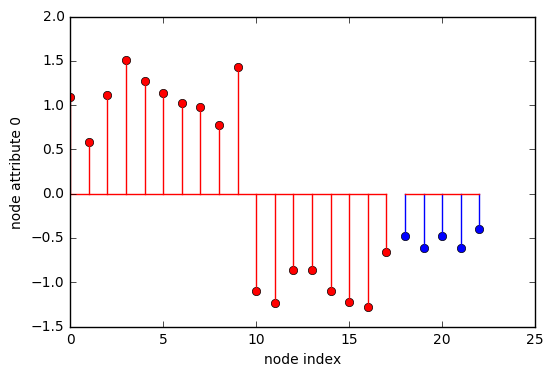

In [12]:
fig1 = plt.figure(1)
(markerline, stemlines, baseline) = plt.stem(np.arange(len(node_sets[0])),X0[0:len(node_sets[0]),0], 'r')
plt.setp(markerline, 'markerfacecolor', 'r')
(markerline, stemlines, baseline) = plt.stem(len(node_sets[0])+np.arange(len(node_sets[1])),X0[len(node_sets[0]):len(G0),0], 'b')
plt.setp(markerline, 'markerfacecolor', 'b')
plt.xlabel('node index')
plt.ylabel('node attribute 0')
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_node_fea0.eps"
if savefigure : fig1.savefig(filename)

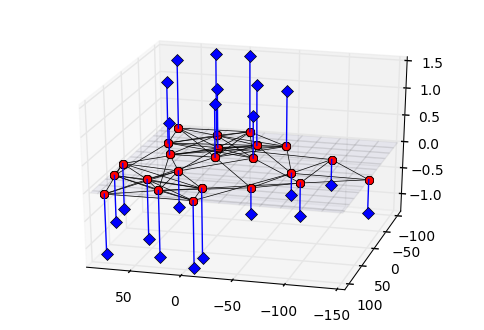

In [13]:
if choice == 'newman' or choice == 'tree':
    pos=nx.circular_layout(G0, dim=2, scale=1.0, center=None)
elif choice == 'grid':
    pos=dict(zip(G0.nodes(), [np.asarray(u) for u in G0.nodes()]))
elif 'bipartite' in choice:
    pos=nx.nx_pydot.graphviz_layout(G0, prog='dot')
else:
    pos=nx.nx_pydot.graphviz_layout(G0)
    
X0_2, nodeIdx = SBN.get_node_attributes(G0_node)
pos_coordinate = np.array([[pos[it['node']][0], pos[it['node']][1]] for it in nodeIdx])

edge_list = SBN.get_edgelist(G0_node)

view_angle = [25, 105] #[25, 180]
SBN.plot_node_3d(pos_coordinate, edge_list, X0_2, view_angle=view_angle, nodeIdx=nodeIdx, save_fig=savefigure)

In [14]:
observed_idx = [item['loc'] for item in nodeIdx if item['node'] in node_sets[0]]
hidden_idx = [item['loc'] for item in nodeIdx if item['node'] in node_sets[1]]
X_o = X0[observed_idx,:]
X_h = X0[hidden_idx,:]
mask = np.ones((len(G0), len(G0)))
mask[np.ix_(observed_idx, observed_idx)] = np.ones((len(node_sets[0]), len(node_sets[0])))

In [15]:
len(observed_idx)

18

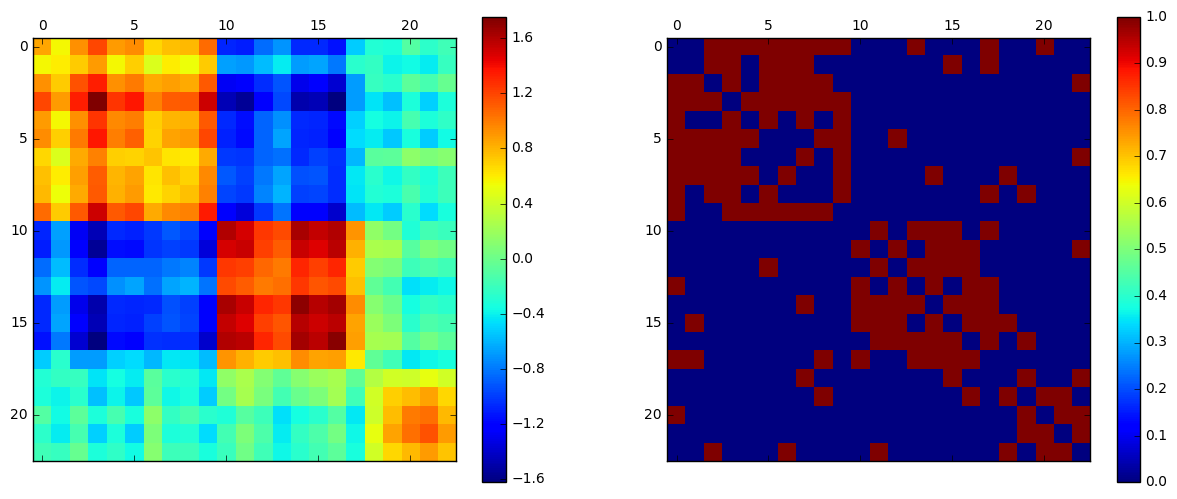

In [16]:
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(np.cov(X0))
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
adjMatSparse =  nx.adjacency_matrix(G0)
adjMat = adjMatSparse.todense()
cax = ax.matshow(adjMat)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_adjmat_all.eps"
if savefigure : fig2.savefig(filename)

##  Learning inverse marginal covariance with gLasso

In [17]:
from graphical_lasso import sparse_inv_cov_glasso 

In [18]:
alpha = 0.65
covariance_margin, precision_margin = sparse_inv_cov_glasso(X_o, alpha=alpha, max_iter = 100)

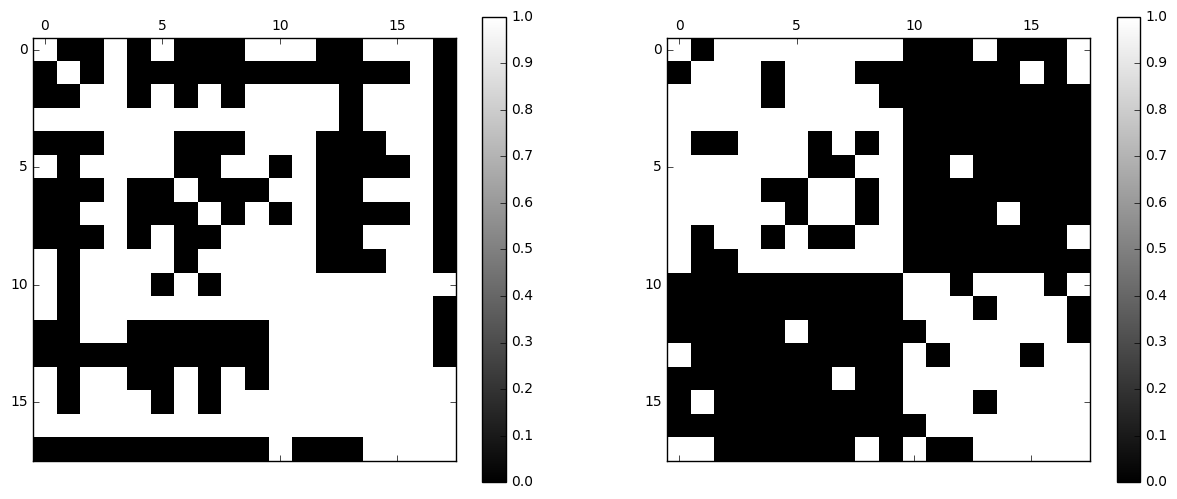

In [19]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(precision_margin)), cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
cax = ax.matshow(sp.sign(abs((Laplacian[np.ix_(node_lists[0], node_lists[0])]))), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian.eps"
if savefigure : fig2.savefig(filename)

##  Use EM-glasso to learn the latent variable sparse inverse covariance estimation

For $t = 1, 2, \ldots, $
 1. M-Step:  find sparse inverse covariance for joint (observerd, latent)
 
    \begin{eqnarray}
     \widehat{\mathbf{\Theta}}_{(o,h),t}^{*} &= \arg\min_{\mathbf{\Theta}} -\frac{m}{2}\log\det\left(\mathbf{\Theta}\right)+ \frac{m}{2}\text{tr}\left(\widehat{\mathbf{\Sigma} }_{(o,h), (t-1)}\left( \mathbf{\Theta}\right)\right) + \alpha_{m}  \|\mathbf{P} \odot \mathbf{\Theta}\|_{1} \\
     &\phantom{=}\text{s.t. }\quad \mathbf{\Theta}\succeq \mathbf{0}  \nonumber
    \end{eqnarray}
    where $\odot$ is piecewise product. and 
    \begin{align}
    \mathbf{P} &= \left[
    \begin{array}{cc}
    \mathbf{J}_{o} & \mathbf{0}_{o,h}\\
    \mathbf{0}_{h,o} & \mathbf{0}_{h}
    \end{array}
    \right]
    \end{align} for $\mathbf{J} \in \mathbb{R}^{o\times o}$ all 1s matrix.
    
 2. E-Step:  find the expected empirical covariance over joint (observed, latent) variables given observed variables
     
     \begin{align}
       \widehat{\mathbf{\Sigma}}_{(o,h), t} \big| \left(\mathbf{\Sigma}_{o}, \widehat{\mathbf{\Theta}}_{(o,h),t}^{*}\right) &= 
       \left[
        \begin{array}{cc}
        \mathbf{\Sigma}_{o} & -\mathbf{\Sigma}_{o}\widehat{\mathbf{\Theta}}_{o,h,t}\\
        -\widehat{\mathbf{\Theta}}_{h,o,t}\mathbf{\Sigma}_{o} & \left(\mathbf{\Sigma}_{h}\right)^{-1} + 
        \widehat{\mathbf{\Theta}}_{h,o,t}\mathbf{\Sigma}_{o}\widehat{\mathbf{\Theta}}_{o,h,t}
        \end{array}
       \right]
     \end{align}
     
     In implementation, we let $\mathbf{\Sigma}_{h} = \mathbf{I}.$

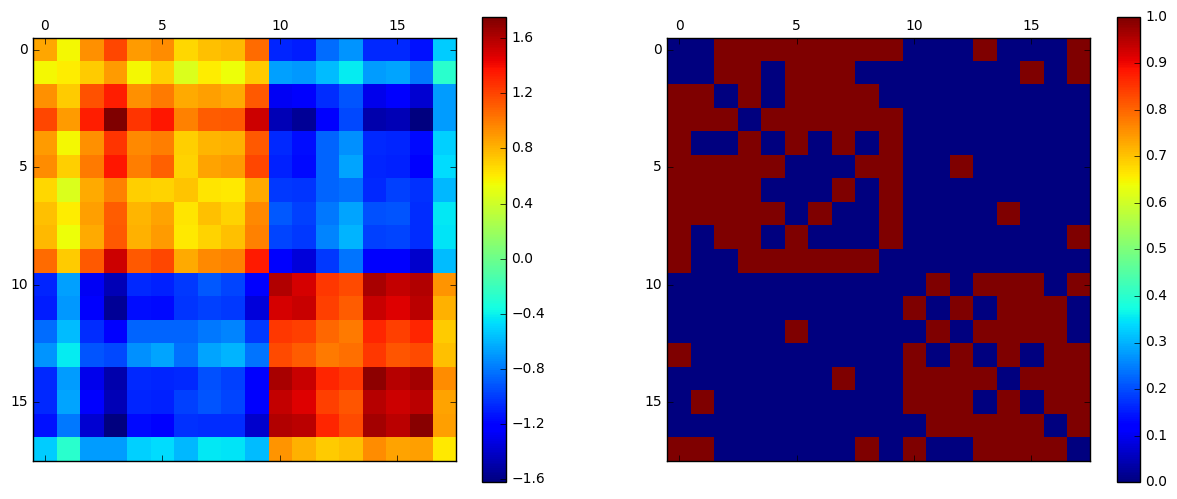

In [20]:
n, m = X_o.shape
emp_cov = np.cov(X_o)
alpha = 0.4
lambda_s = 1
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(emp_cov)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
adjMatSparse =  nx.adjacency_matrix(G0)
adjMat = adjMatSparse.todense()
cax = ax.matshow(adjMat[np.ix_(observed_idx, observed_idx)])
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_adjmat.eps"
if savefigure : fig2.savefig(filename)

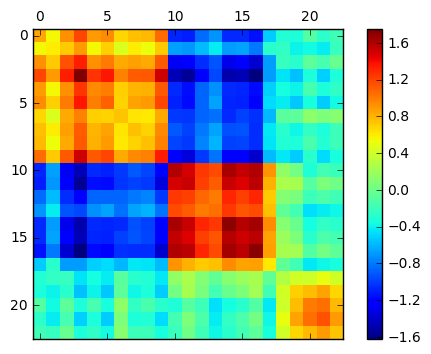

In [21]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(np.cov(X0))
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_all.eps"
if savefigure : fig2.savefig(filename)

In [22]:
from latent_graphical_lasso import latent_variable_glasso_data

/home/tianpei/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
alpha = 0.015
covariance_em_o, precision_em_o, _, prec_all_list_em = \
                    latent_variable_glasso_data(X_o, X_h, alpha=alpha, max_iter_out = 5, max_iter_in=100, 
                                               verbose=True, return_hists=True)

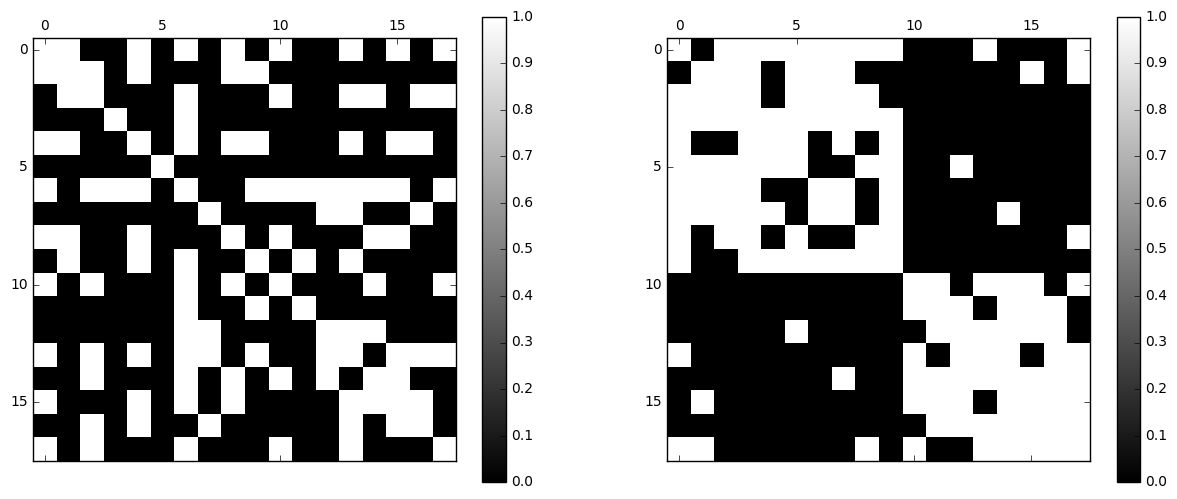

In [24]:
import pywt
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(pywt.threshold(precision_em_o, 1e-3, 'hard'))), cmap=plt.cm.gray)
fig2.colorbar(cax)
ax = fig2.add_subplot(122)



cax = ax.matshow(sp.sign(abs((Laplacian[np.ix_(node_lists[0], node_lists[0])]))), cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_em.eps"
if savefigure : fig2.savefig(filename)

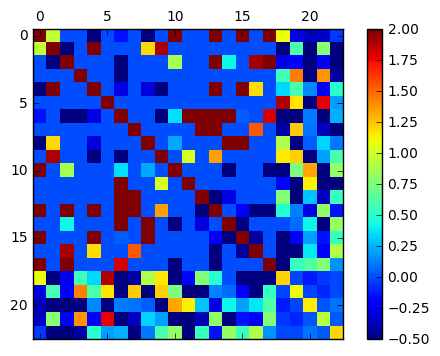

In [25]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[-1], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em.eps"
if savefigure : fig2.savefig(filename)

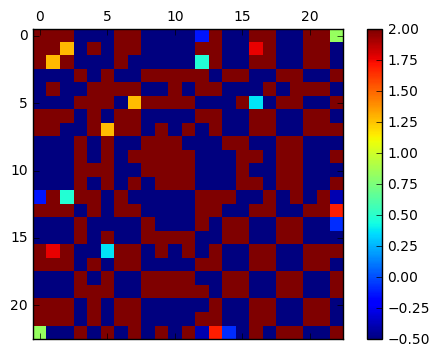

In [26]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[0], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_0.eps"
if savefigure : fig2.savefig(filename)

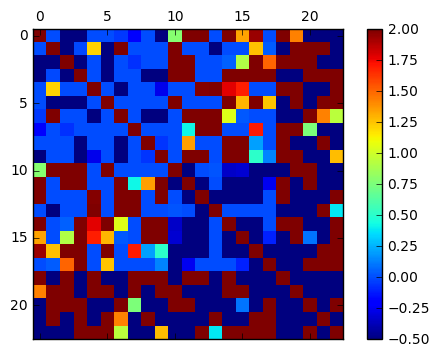

In [27]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[1],  vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_1.eps"
if savefigure : fig2.savefig(filename)

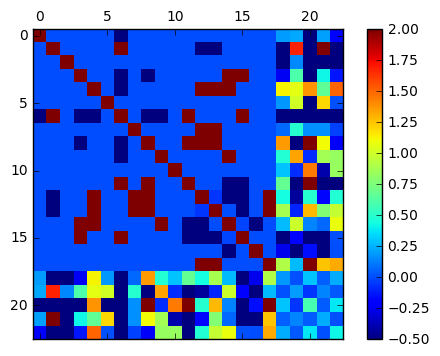

In [28]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[2], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_2.eps"
if savefigure : fig2.savefig(filename)

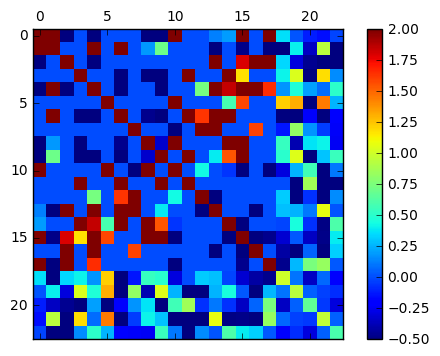

In [29]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[3], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_3.eps"
if savefigure : fig2.savefig(filename)

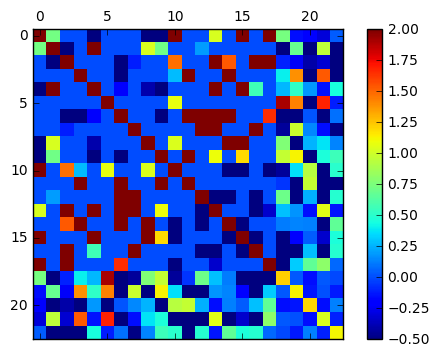

In [30]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[4], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_4.eps"
if savefigure : fig2.savefig(filename)

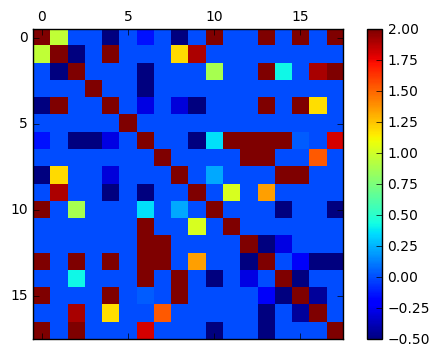

In [31]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(precision_em_o, vmin=-0.5, vmax=2)
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_o_em.eps"
if savefigure : fig2.savefig(filename)

See that the estimated precision matrix by latent-variable-gmm is not sparse. 